# Cross Entropy
> PyTorch와 Numpy로 구현하는 Cross Entropy

- toc: true 
- badges: true
- comments: true
- categories: [Implementation, AI-math]
- image: images/cross_entropy_fig1.png

# Introduction

본 포스팅에서는 Cross Entropy에 대해 알아보겠습니다.

- Cross Entropy의 개념
- Cross Entropy 수식
- Matplotlib으로 figure 그려보기
- Numpy로 코드 구현체 살펴보기
- PyTorch로 forward, backward pass 수식과 함께 이해하기
- PyTorch 결과값과 동일한 출력이 나오도록 코드 수정

# Cross Entropy란?

Cross entropy는 random variable(확률 변수) 혹은 set of events(사건 집합)이 주어졌을 때 서로 다른 두 확률 분포 사이의 차이를 재는 measure입니다.

## Entropy


Event $x$가 등장할 확률을 $P(x)$라고 두고 이에 대한 정보량 $h(x)$에 대한 수식은 아래와 같이 정의됩니다.

$$h(x)=-\log{P(x)}$$

$\log$ 함수의 그래프에 음수를 씌우면 아래와 같이 그릴 수 있습니다.

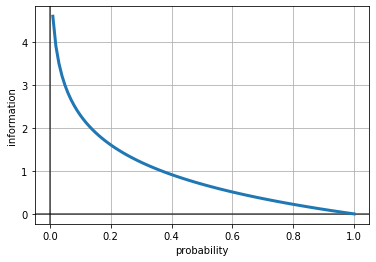

In [39]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.01, 1, 100)
y = - np.log(x)
plt.axvline(0, color="k", alpha=0.7)
plt.axhline(0, color="k", alpha=0.7)
plt.plot(x, y, lw=3)
plt.xlabel("probability")
plt.ylabel("information")
plt.grid()
_ = plt.plot()

위 그래프로부터 아래의 사실을 확인할 수 있습니다.
- $P(x)$가 `0.0`에 가까울 때 (사건이 등장할 확률이 희박할 때) 해당 사건에 대한 정보량이 높음을 알 수 있습니다.
- $P(x)$가 `1.0`에 가까울 때 (사건이 등장할 확률이 높을 때) 해당 사건에 대한 정보량이 낮음을 알 수 있습니다.

때문에 이를 정보 이론에서는 `surprise` 라고 묘사합니다. 우리가 매일 마주하는 일상에서는 크게 놀랄만한 정보가 없습니다. 그러나 취업을 했달지 연애를 시작한다던지 인생에 드물게 찾아오는 사건이 생기면 우리는 이 기쁨에 취하며 놀라곤 합니다.

즉, 드물게 발생할 수록 더욱 정보량이 높은 것이지요.

단일 사건에 대한 정보량말고 set of $x$, $X$를 생각해보겠습니다. $X$는 이산 확률 분포라고 가정할게요. 그러면 다음과 같이 식을 적을 수 있습니다.

$$H(X)=-\sum_{x\in X}P(x)\cdot\log{P(x)}$$

$X$의 모든 사건 $x$에 대한 정보량들을 더한 값을 $X$에 대한 정보량으로 생각할 수 있다라고 식이 적혀있습니다. Entropy는 가능한 모든 사건이 발생할 확률이 전부 같을 때 최댓값을 가집니다. 각각의 정보량은 발생할 확률이 작을수록 값이 커지기 때문이죠.

## 이산변수의 Entropy

Discrete variable의 기댓값은 summation으로 쓸 수 있습니다. 위의 수식을 잘 살펴보죠. 기댓값의 수식이죠?

$$
\begin{aligned}\\
H(X)&=-\sum_{x\in X}P(x)\cdot\log{P(x)}\\
&=\sum_{x\in X}P(x)\cdot(-\log{P(x)})\\
&=\mathbb{E}\big[-\log{P(x)}\big]\\
\end{aligned}
$$

위 수식을 잘 기억해주세요. 이산변수는 기댓값을 합으로 계산하기 때문에 아래와 같이 쉽게 계산할 수 있습니다.

확률 분포 Y가 이산분포이고 다음과 같다고 가정해보겠습니다.
- 확률 분포 $Y_1$: $P(Y=0)=0.8,\;P(Y=1)=0.2$

$Y_1$에 대한 entropy를 정의된 식과 같이 동일하게 계산할 수 있습니다.

In [405]:
p_y = [0.8, 0.2]

sum([p * -np.log2(p) for p in p_y])

0.7219280948873623

## 연속변수의 Entropy

이와는 다르게 Continuous variable의 기댓값은 Integral로 쓸 수 있습니다.

$$
\begin{aligned}\\
H(X)&=\mathbb{E}\big[-\log{P(X)}\big]\\
&=\int_{-\infty}^{\infty}{P(X)\cdot(-\log{P(X)})}dx
\end{aligned}
$$

위를 trapezoidal rule을 사용하여 적분값을 계산해보겠습니다.

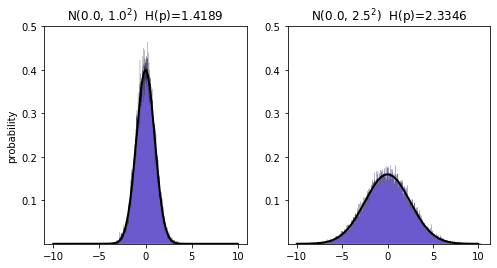

In [423]:
def normal(x, mu, sigma):
    var = sigma ** 2
    x = x - mu
    return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-x**2 / (2 * var))

entropy = lambda p: -p * np.log(p)

def trapezoidal_rule(dt, p, f):
    return np.sum((f(p[:-1]) + f(p[1:])) * dt) / 2

xlim, ylim, n_sample, n_bin = 10, 0.5, 50000, 1000
yticks = [0.1, 0.2, 0.3, 0.4, 0.5]
mu1, mu2 = 0.0, 0.0
sigma1, sigma2 = 1.0, 2.5
x = np.linspace(-xlim, xlim, n_sample)
X1 = np.random.normal(loc=mu1, scale=sigma1, size=(n_sample))
X2 = np.random.normal(loc=mu2, scale=sigma2, size=(n_sample))

fig = plt.figure(figsize=(8, 4))

def plot_normal_entropy(ax, X, mu, sigma):
    _, bins, _ = ax.hist(X, bins=n_bin, density=True, histtype="stepfilled", 
                         color="slateblue", edgecolor="k", lw=0.1)
    ax.plot(x, normal(x, mu, sigma), color="k", lw=2)
    ax.set_ylim(0, ylim)
    ax.set_yticks(yticks)
    dt = np.diff(bins)
    p = normal(bins, mu, sigma)
    ent = trapezoidal_rule(dt, p, entropy)
    ax.set_title(rf"N(${mu}$, ${sigma}^2$)  H(p)={ent:.4f}")

plot_normal_entropy(fig.add_subplot(1, 2, 1), X1, mu1, sigma1)
plt.ylabel("probability")
plot_normal_entropy(fig.add_subplot(1, 2, 2), X2, mu2, sigma2)
_ = plt.plot()

위처럼 직접 적분값을 근사하여 계산할 수도 있지만 정규 분포 엔트로피 값을 해석적으로도 계산할 수 있습니다.

정규 분포의 수식은 아래와 같습니다.

$$P(X)=\cfrac{1}{\sqrt{2\pi\sigma^2}}\exp{\bigg(\cfrac{-(X-\mu)^2}{2\sigma^2}\bigg)}$$

이제 엔트로피 수식을 전개해봅시다.

$$
\begin{aligned}\\
H(X)&=\mathbb{E}\big[-\log{P(X)}\big]\\
&=\int_{-\infty}^{\infty}{P(X)\cdot(-\log{P(X)})}dX
\end{aligned}
$$

여기서 $-\log P(X)$는 $\cfrac{1}{2}\log{2\pi\sigma^2}+\cfrac{1}{2\sigma^2}(X-\mu)^2$이고 이를 대입하면

$$
H(X)=\cfrac{1}{2}\log{2\pi\sigma^2}\int_{-\infty}^{\infty}{P(X)}dX+\cfrac{1}
{2\sigma^2}\int_{-\infty}^{\infty}(X-\mu)^2P(X)dX
$$

여기서 확률 및 분산의 정의에 따라 다음을 알 수 있고

$$\int_{-\infty}^{\infty}{P(X)}dX=1$$
$$\int_{-\infty}^{\infty}(X-\mu)^2P(X)dX=\sigma^2$$

이를 사용하여 식을 다시 작성하면

$$H(X)=\cfrac{1}{2}\big(\log{2\pi\sigma^2}+1\big)$$

와 같이 쓸 수 있습니다.

python code로 구현하여 위의 결과와 비교해봅시다.

In [425]:
def normal_entropy(sigma):
    # return 0.5 * np.log(np.e * 2 * np.pi * sigma**2)
    return 0.5 * (1 + np.log(2 * np.pi * sigma**2))

normal_entropy(sigma1)

1.4189385332046727

## Cross Entropy

Machine Learning: A Probabilistic Perspective에서는 cross entropy를 다음과 같이 설명합니다.

```
The cross entropy is the average number of bits needed to encode data coming from a source with distribution p when we use model q ...
```

$P$는 모델링하고자 하는 분포, $Q$는 모델링을 할 분포라고 생각하면 이해가 빠릅니다. $P$ 대신 $Q$를 사용하여 사건을 나타내는 총 비트의 평균 수 입니다.

$$H(P,Q)=-\sum_{x\in X}P(x)\cdot\log Q(x)$$

총 비트 수가 아니라 추가로 필요한 비트의 평균값은? `relative entropy`, `Kullback-Leibler Divergence` 라고 합니다.

$$KL(P||Q)=-\sum_{x\in X}P(x)\cdot\log{\cfrac{Q(x)}{P(x)}}$$

위 수식은 Entropy와 엮어서 다음과 같이 쓸 수 있습니다.

$$
\begin{aligned}\\
H(P)&=\sum_{x \in X} P(x)\cdot\log P(x)\\
&=H(P,Q)-KL(P||Q)
\end{aligned}
$$

## Cross-entropy and Maximum Likelihood Estimation

분류 문제를 풀기 위해 Neural Network를 학습시킬 때, 우리는 흔히 Cross Entropy로 학습시킵니다. 왜일까요?

위에서 Entropy, Cross Entropy, KL-Divergence에 대한 수식을 정의했습니다.

앞서 확률 변수의 Entropy 정의에서 Entropy가 확률 변수의 Expectation과 관련이 있음을 확인했었습니다. 각각을 기댓값 표현으로 써보면,

$$
\begin{aligned}\\
H(X)&=-\sum_x p(x)\log p(x)\\
&=\sum_x -p(x)\log p(x)\\
&=\sum_x p(x)\log \cfrac{1}{p(x)}\\
&=\mathbb{E}_{X\sim p(x)}\bigg[\log \cfrac{1}{p(x)}\bigg]
\end{aligned}
$$

$$
\begin{aligned}\\
KL(p||q)&=\sum_x p(x)\log \cfrac{p(x)}{q(x)}\\
&=\mathbb{E}_{X\sim p(x)}\bigg[\log\cfrac{p(x)}{q(x)}\bigg]\\
&=\mathbb{E}_{X\sim p(x)}\bigg[\log\cfrac{1}{q(x)}-\cfrac{1}{p(x)}\bigg]\\
&=\mathbb{E}_{X\sim p(x)}\bigg[\log\cfrac{1}{q(x)}\bigg]-\mathbb{E}_{X\sim p(x)}\bigg[\log\cfrac{1}{p(x)}\bigg]\\
&=\mathbb{E}_{X\sim p(x)}\bigg[\log\cfrac{1}{q(x)}\bigg] - H(p)
\end{aligned}
$$

Cross entropy는 아래와 같이 적을 수 있죠.

$$H(p,q)=\mathbb{E}_{X\sim p(x)}\bigg[\log\cfrac{1}{q(x)}\bigg]$$

그러면 Maximum Likelihood Estimation에서의 objective function을 살펴보겠습니다.

우리는 분포 $p$를 모델링하고 싶습니다. 이에 대한 데이터 $X$를 모수 $\theta$를 가지는 parametric model $q$로 모델링하면 아래와 같이 수식을 쓸 수 있습니다.

$$\theta_{ML}=\underset{\theta}{\mathrm{argmax}}\;q(X;\theta)$$

i.i.d 가정에 의해 아래와 같이 수식을 작성하면 (로그 스케일로)

$$
\begin{aligned}\\
\theta_{ML}&=\underset{\theta}{\mathrm{argmax}}\;\prod_{i=1}^{m}q(x_i;\theta)\\
&=\underset{\theta}{\mathrm{argmax}}\;\sum_{i=1}^{m}\log q(x_i;\theta)\\
&=\underset{\theta}{\mathrm{argmax}}\;\sum_{i=1}^{m}\frac{1}{m}\log q(x_i;\theta)\\
&=\underset{\theta}{\mathrm{argmax}}\;\mathbb{E}_{X\sim p(x)}\big[\log q(x)\big]\\
&=\underset{\theta}{\mathrm{argmin}}\;-\mathbb{E}_{X\sim p(x)}\big[\log q(x)\big]\\
&=\underset{\theta}{\mathrm{argmin}}\;\mathbb{E}_{X\sim p(x)}\big[\log\frac{1}{q(x)}\big]\\
\end{aligned}
$$

즉, Likelihood를 maximize하는 문제는 Cross Entropy를 Minimize하는 문제로 치환할 수 있습니다.

# Code Implementation

Cross Entropy를 구현해봅시다.

## Library 호출

In [558]:
import math
import numbers
from typing import Optional, Tuple, Sequence, Union, Any

import numpy as np

import torch
import torch.nn as nn

_TensorOrTensors = Union[torch.Tensor, Sequence[torch.Tensor]]

## Numpy로 구현하기: forward

Cross Entropy는 `LogSoftmax`와 `NegativeLogLikelihood`로 계산할 수 있습니다. 위에서 본 것처럼 우도를 최대화하는 문제와 Cross entropy를 최소화하는 문제는 동일하기 때문에 이를 Negative Log likelihood를 최소화하는 문제로 생각해도 무방하겠죠? 이를 활용하여 Cross entropy를 구해봅시다.

한 가지, 구현 테크닉을 소개드리고자 합니다. softmax 함수는 다음과 같은 특징을 가지고 있습니다.

$$\mathrm{softmax}(x)=\mathrm{softmax}(x+c)$$

이를 활용하여 overflow 문제를 해결할 수 있습니다.

$$\mathrm{softmax}(x_i)=\cfrac{exp(x_i)}{\sum_j exp(x_j)}$$

In [459]:
def log_softmax_numpy(arr):
    c = np.amax(arr, axis=-1, keepdims=True)
    s = arr - c
    nominator = np.exp(s)
    denominator = nominator.sum(axis=-1, keepdims=True)
    probs = nominator / denominator
    return np.log(probs)

우도는 fancy indexing으로 간단하게 계산할 수 있습니다. 구한 likelihood에 음수를 씌워주면 Negative Likelihood가 되겠지요.

구한 Negative Log Likelihood는 평균값으로 reduce하겠습니다.

In [460]:
def negative_log_likelihood_numpy(y_pred, y):
    log_likelihood = y_pred[np.arange(y_pred.shape[0]), y]
    nll = -log_likelihood
    return nll.mean()

Cross entropy는 이제 간단합니다. 예측 값 Q에 log softmax를 취해주고 음의 로그 가능도를 계산해주면 됩니다.

In [461]:
def cross_entropy_numpy(y_pred, y):
    log_probs = log_softmax_numpy(y_pred)
    ce_loss = negative_log_likelihood_numpy(log_probs, y)
    return ce_loss

## PyTorch로 구현하기: forward

이를 pytorch로도 구현해봅시다. 구현은 메서드명까지 동일합니다. 차이라면 numpy에서는 차원축을 axis라는 parameter로 받는 반면, torch는 dim이라는 parameter로 받습니다.

In [466]:
def log_softmax_torch(tensor):
    c = torch.amax(tensor, dim=-1, keepdims=True)
    s = tensor - c
    nominator = torch.exp(s)
    denominator = nominator.sum(dim=-1, keepdims=True)
    probs = nominator / denominator
    return torch.log(probs)


def negative_log_likelihood_torch(y_pred, y):
    log_likelihood = y_pred[torch.arange(y_pred.shape[0]), y]
    nll = -log_likelihood
    return nll.mean()


def cross_entropy_torch(y_pred, y):
    log_probs = log_softmax_torch(y_pred)
    ce_loss = negative_log_likelihood_torch(log_probs, y)
    return ce_loss

## forward 결과값 비교

In [467]:
import random
from functools import partial

batch_size = 8
vocab_size = 3000

rtol = 1e-4
atol = 1e-6
isclose = partial(torch.isclose, rtol=rtol, atol=atol)

In [468]:
y_pred = [
    [random.normalvariate(mu=0., sigma=1.) for _ in range(vocab_size)]
    for _ in range(batch_size)
]
y_pred_torch = torch.FloatTensor(y_pred)
y_pred_torch.requires_grad = True
y_pred_numpy = y_pred_torch.detach().numpy()

y = [random.randint(0, vocab_size) for _ in range(batch_size)]
y_torch = torch.LongTensor(y)
y_numpy = y_torch.numpy()

In [469]:
ce_result = nn.CrossEntropyLoss()(y_pred_torch, y_torch)
ce_numpy = cross_entropy_numpy(y_pred_numpy, y_numpy)
ce_torch = cross_entropy_torch(y_pred_torch, y_torch)

try:
    isclose(ce_result, ce_torch).item()
    isclose(ce_result, torch.tensor(ce_numpy)).item()
    success = True
except:
    success = False

print("Do both output the same tensors?", "🔥" if success else "💩")
if not success:
    raise Exeption("Something went wrong")

Do both output the same tensors? 🔥


## PyTorch로 구현하기: backward

### Log Softmax

$$o(1-o)$$
- 1은 크로네클 델타
- log softmax가 계산 상 이점이 큼
- loss를 더 크게 만들어 주기도
- softmax의 backward의 grad_outputs에 log 함수의 역함수인 1/x를 넣어주면 log_softmax의 backward form이 나온다.

In [540]:
def _softmax(tensor: torch.Tensor, dim: int = -1) -> torch.Tensor:
    c = torch.amax(tensor, dim=dim, keepdims=True)
    s = tensor - c
    nominator = torch.exp(s)
    denominator = nominator.sum(dim=dim, keepdims=True)
    probs = nominator / denominator
    return probs


class Softmax(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx: Any, tensor: Any, dim: int = -1) -> Any:
        probs = _softmax(tensor)
        ctx.save_for_backward(probs, torch.tensor(dim))
        return probs
    
    @staticmethod
    def backward(ctx: Any, grad_outputs: Any) -> Any:
        probs, dim, = ctx.saved_tensors
        grad_outputs -= (grad_outputs * probs).sum(dim.item(), keepdims=True)
        return probs * grad_outputs, None


softmax = Softmax.apply


class LogSoftmax(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx: Any, tensor: Any, dim: int = -1) -> Any:
        probs = _softmax(tensor)
        ctx.save_for_backward(probs, torch.tensor(dim))
        return torch.log(probs)
    
    @staticmethod
    def backward(ctx: Any, grad_outputs: Any) -> Any:
        probs, dim, = ctx.saved_tensors
        grad_outputs -= probs * grad_outputs.sum(dim=dim.item(), keepdims=True)
        return grad_outputs, None
    

log_softmax = LogSoftmax.apply

In [553]:
x = torch.randn(5, 3, requires_grad=True)

# Softmax check
# -- forward pass
y_orig = nn.functional.softmax(x, dim=-1)
y_impl = y = softmax(x, -1)
assert isclose(y_orig, y_impl).all(), "💩"
# -- backward pass
dy_orig = torch.autograd.grad(y_orig, x, torch.ones_like(x), retain_graph=True)[0]
dy_impl = torch.autograd.grad(y_impl, x, torch.ones_like(x), retain_graph=True)[0]
assert isclose(dy_orig, dy_impl).all(), "💩"

# LogSoftmax check
# -- forward pass
y_orig = nn.functional.log_softmax(x, dim=-1)
y_impl = y = log_softmax(x, -1)
assert isclose(y_orig, y_impl).all(), "💩"
# -- backward pass
dy_orig = torch.autograd.grad(y_orig, x, torch.ones_like(x), retain_graph=True)[0]
dy_impl = torch.autograd.grad(y_impl, x, torch.ones_like(x), retain_graph=True)[0]
assert isclose(dy_orig, dy_impl).all(), "💩"

# Log + Softmax check
# -- forward pass
y1 = torch.log(softmax(x, -1))
y2 = log_softmax(x, -1)
assert isclose(y1, y2).all(), "💩"
# -- backward pass
dy1 = torch.autograd.grad(y1, x, torch.ones_like(x), retain_graph=True)[0]
dy2 = torch.autograd.grad(y2, x, torch.ones_like(x), retain_graph=True)[0]
assert isclose(dy1, dy2).all(), "💩"

print("🔥")

🔥


## Negative Log Likelihood

In [555]:
class NegativeLogLikelihoodLoss(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx: Any, y_pred: Any, y: Any) -> Any:
        bsz, n_classes = torch.tensor(y_pred.size())
        ctx.save_for_backward(bsz, n_classes, y)
        log_likelihood = y_pred[torch.arange(bsz), y]
        nll = -log_likelihood
        return nll.mean()
    
    @staticmethod
    def backward(ctx: Any, grad_outputs: Any) -> Any:
        bsz, n_classes, y, = ctx.saved_tensors
        grad_outputs = grad_outputs.expand(bsz) / bsz
        negative_grad = -grad_outputs
        ll_grad = torch.zeros(bsz, n_classes, device=grad_outputs.device)
        ll_grad[torch.arange(bsz), y] = 1.
        grad_outputs = torch.diag(negative_grad) @ ll_grad
        return grad_outputs, None
    
nll_loss = NegativeLogLikelihoodLoss.apply

## Cross Entropy

In [559]:
class CrossEntropyLoss(nn.Module):
    
    def forward(
        self, 
        y_pred: _TensorOrTensors, 
        y: _TensorOrTensors
    ) -> _TensorOrTensors:
        log_probs = log_softmax(y_pred)
        ce_loss = nll_loss(log_probs, y)
        probs = torch.exp(log_probs) / log_probs.size(0)
        self.save_for_backward(probs, y, y_pred.size(-1))
        return ce_loss
    
    def save_for_backward(self, *args):
        self.saved_tensors = args
        
    @torch.no_grad()
    def backward(self, grad_outputs: _TensorOrTensors) -> _TensorOrTensors:
        probs, y, num_classes, = self.saved_tensors
        ce_grad = probs - torch.nn.functional.one_hot(y, num_classes=num_classes)
        return grad_outputs * ce_grad

## put everything together
- 위의 세 모듈을 한데 모아 구현
- `ignore_index`, `reduction` 추가 구현
- 설명은 시간이 되면 추가로 포스팅 업데이트

In [560]:
class LogSoftmax(torch.autograd.Function):

    @staticmethod
    def forward(ctx: Any, tensor: Any, dim: int = -1) -> Any:
        # softmax(x) = softmax(x+c)
        c = torch.amax(tensor, dim=dim, keepdims=True)
        s = tensor - c
        # Calculate softmax
        nominator = torch.exp(s)
        denominator = nominator.sum(dim=dim, keepdims=True)
        probs = nominator / denominator
        # Calculate log
        log_probs = torch.log(probs)
        ctx.save_for_backward(probs, torch.tensor(dim))
        return log_probs

    @staticmethod
    def backward(ctx: Any, grad_outputs: Any) -> Any:
        # https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/SoftMax.cpp#L219
        probs, dim, = ctx.saved_tensors
        grad_outputs -= probs * grad_outputs.sum(dim=dim.item(), keepdims=True)
        return grad_outputs, None


class NegativeLogLikelihoodLoss(torch.autograd.Function):

    @staticmethod
    def forward(ctx: Any, y_pred: Any, y: Any, dim: int = -1, 
                reduce: str = "mean", ignore_index: int = -1) -> Any:
        bsz, n_classes = torch.tensor(y_pred.size())
        mask = y.ne(ignore_index)
        ctx.save_for_backward(
            bsz, n_classes, y, 
            torch.tensor(dim), mask,
            torch.tensor({"mean": 0, "sum": 1, "none": 2}.get(reduce, -1)),
            torch.tensor(ignore_index)
        )
        dim_x = torch.arange(bsz) if dim != 0 else y
        dim_y = y if dim != 0 else torch.arange(bsz)
        log_likelihood = y_pred[dim_x, dim_y] # Calculate Log Likelihood
        nll = -log_likelihood # Calculate Negative Log Likelihood
        # Calculate Loss
        if reduce == "mean":
            return torch.mean(nll[mask])
        elif reduce == "sum":
            return torch.sum(nll[mask])
        nll[~mask] = 0.
        return nll

    @staticmethod
    def backward(ctx: Any, grad_outputs: Any) -> Any:
        bsz, n_classes, y, dim, mask, reduce, ignore_index, = ctx.saved_tensors
        if reduce.item() != 2: # reduce case
            grad_outputs = grad_outputs.expand(bsz)
        if reduce.item() == 0: # mean case
            grad_outputs = grad_outputs / mask.sum()
        negative_mean_grad = -grad_outputs # backward negative
        # backward log likelihood (indexing)
        if dim.item() != 0:
            ll_grad = torch.zeros(bsz, n_classes, device=grad_outputs.device)
            ll_grad[torch.arange(bsz), y] = 1
            ll_grad[torch.arange(bsz), ignore_index.item()] = 0
        else:
            ll_grad = torch.zeros(n_classes, bsz, device=grad_outputs.device)
            ll_grad[y, torch.arange(bsz)] = 1
            ll_grad[ignore_index.item(), torch.arange(bsz)] = 0
        grad_outputs = torch.diag(negative_mean_grad) @ ll_grad
        return grad_outputs, None, None, None, None


class CrossEntropyLoss(nn.Module):
    
    log_softmax = LogSoftmax.apply
    negative_log_likelihood = NegativeLogLikelihoodLoss.apply
    
    def __init__(self, reduce: str = "mean", ignore_index: int = -1):
        super().__init__()
        self.reduce = reduce
        self.ignore_index = ignore_index

    def forward(
        self, 
        y_pred: _TensorOrTensors, 
        y: _TensorOrTensors,
        dim: int = -1,
    ) -> _TensorOrTensors:
        log_probs = self.log_softmax(y_pred, dim)
        ce_loss = self.negative_log_likelihood(
            log_probs, y, dim, self.reduce, self.ignore_index)
        probs = torch.exp(log_probs)
        self.save_for_backward(probs, y, y_pred.size(0), y_pred.size(-1))
        return ce_loss

    def save_for_backward(self, *args):
        self.saved_tensors = args

    @torch.no_grad()
    def backward(self, grad_outputs: _TensorOrTensors) -> _TensorOrTensors:
        probs, y, bsz, num_classes, = self.saved_tensors
        y = torch.nn.functional.one_hot(y, num_classes=num_classes)
        ce_grad = probs - y
        if self.reduce == "mean":
            ce_grad = ce_grad / bsz
        return grad_outputs * ce_grad

# Reference
- https://machinelearningmastery.com/cross-entropy-for-machine-learning/
- https://stackoverflow.com/questions/61567597/how-is-log-softmax-implemented-to-compute-its-value-and-gradient-with-better
- https://math.stackexchange.com/questions/1804805/how-is-the-entropy-of-the-normal-distribution-derived
- https://datascienceschool.net/02%20mathematics/10.01%20%EC%97%94%ED%8A%B8%EB%A1%9C%ED%94%BC.html
- https://medium.com/konvergen/cross-entropy-and-maximum-likelihood-estimation-58942b52517a
- https://discuss.pytorch.org/t/logsoftmax-vs-softmax/21386/4
- https://stackoverflow.com/questions/61567597/how-is-log-softmax-implemented-to-compute-its-value-and-gradient-with-better
- https://github.com/pytorch/pytorch/issues/31829
- https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/SoftMax.cpp#L219
- https://github.com/jinmang2/boostcamp_ai_tech_2/blob/main/u-stage/nlp/ch03_rnn/implement_rnn.py